In [11]:
from src.data.get_dataset import get_merged_datasets
dataframe = get_merged_datasets()

dataframe.shape

(3104, 204)

In [37]:
numeric_cols = dataframe.select_dtypes(include=['number']).columns.difference(['year']).tolist() #we don't want year to be a feature in our prediction model
#we want to limit our feature set to columns without any data leaks, since in real prediction we wouldn't know those values.
data_leak_list = ["co2", "ghg", "greenhouse_gas", "nitrous_oxide", "methane", "ch4", "n2o", "change"]

def is_data_leak(s):
    for data_leak in data_leak_list: 
        if data_leak in s:
            return True
        
    return False
feature_list = []    
for x in numeric_cols: 
    is_leak = is_data_leak(x)
    if not is_leak: 
        feature_list.append(x)
print(feature_list)

['agricultural_land_area_in_hectares', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'carbon_intensity_elec', 'coal_cons_per_capita', 'coal_consumption', 'coal_elec_per_capita', 'coal_electricity', 'coal_prod_per_capita', 'coal_production', 'coal_share_elec', 'coal_share_energy', 'cropland_area_in_hectares', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_per_capita', 'energy_per_gdp', 'forest_land_area_in_hectares', 'fossil_elec_per_capita', 'fossil_electricity', 'fossil_energy_per_capita', 'fossil_fuel_consumption', 'fossil_share_elec', 'fossil_share_energy', 'gas_consumption', 'gas_elec_per_capita', 'gas_electricity', 'gas_energy_per_capita', 'gas_prod_per_capita', 'gas_production', 'gas_share_elec', 'gas_share_energy', 'gdp', 'hydro_consumption', 'hydro_elec_per_capita', 'hydro_electricity', 'hydro_energy_per_capita', 'hydro_share_elec', 'hydro_sha

In [38]:
#checking correlations between various features and co2 data
dataframe[feature_list + ['co2']].corr()['co2'].sort_values(ascending=False) #Reduced feature list to 97, need to check if any of these are unrelated. 

co2                           1.000000
fossil_fuel_consumption       0.992006
fossil_electricity            0.990423
primary_energy_consumption    0.987311
electricity_generation        0.979749
                                ...   
hydro_share_elec             -0.112958
renewables_share_elec        -0.115668
oil_share_elec               -0.146162
nuclear_share_energy         -0.164512
oil_share_energy             -0.173952
Name: co2, Length: 98, dtype: float64

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#test if I can hand-pick a few features avoiding most of the repeats. 
feature_list = ['fossil_electricity','coal_electricity', 'oil_electricity', 'hydro_electricity', 'wind_electricity', 'primary_energy_consumption', 'electricity_demand', 'gdp', 'low_carbon_electricity', 'renewables_electricity', 'agricultural_land_area_in_hectares', 'cropland_area_in_hectares', 'population', 'nuclear_electricity', 'forest_land_area_in_hectares', 'median_age', 'solar_electricity' ]

X = dataframe[feature_list]
Y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

simple_imputer = SimpleImputer(strategy='mean')

#fit imputer on training set, and fit both train and test
simple_imputer.fit(X_train)

X_train = simple_imputer.transform(X_train)
X_test = simple_imputer.transform(X_test)

scalar = StandardScaler() #RobustScaler(with_scaling=True, with_centering=True) I tried the robust scalar to reduce outliers, it didn't make a difference. 
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [76]:
# Let's train a basic model for testing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42) 
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train, y_train) for x in models ] #train all models

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [79]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

training_predictions = [m.predict(X_train) for m in models]
mean_sq_errors = [mean_squared_error(y_train, y) for y in training_predictions]
r2_scores = [r2_score(y_train, y) for y in training_predictions]
adj_r2_scores = [((1 - score)*(len(y_train)-1)/(len(y_train)-X_test.shape[1]-1)) for score in r2_scores]
print("Train data scores")
[print(f" {models[i].__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}") for i in range(0, len(models))]

Train data scores
 LinearRegression: Mean Squared Error: 905.2362838891642, R2_score 0.9982262802663079, Adjusted R2 score: 0.0017859522835796458
 Ridge: Mean Squared Error: 928.0286833766551, R2_score 0.9981816208448191, Adjusted R2 score: 0.0018309197010787043
 Lasso: Mean Squared Error: 1153.7961372144807, R2_score 0.9977392521558652, Adjusted R2 score: 0.0022763392085770784
 DecisionTreeRegressor: Mean Squared Error: 3.723102590841213e-36, R2_score 1.0, Adjusted R2 score: 0.0
 RandomForestRegressor: Mean Squared Error: 303.59374288815064, R2_score 0.9994051385009971, Adjusted R2 score: 0.0005989639920994683
 SGDRegressor: Mean Squared Error: 2542.917435390872, R2_score 0.9950174082539817, Adjusted R2 score: 0.0050169544477150175


[None, None, None, None, None, None]

In [71]:

predictions = [m.predict(X_test) for m in models]
mean_sq_errors = [mean_squared_error(y_test, y_) for y_ in predictions]
r2_scores = [r2_score(y_test, y_) for y_ in predictions]
adj_r2_scores = [((1 - score)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)) for score in r2_scores]
print("Test data scores")
[print(f" {models[i].__class__.__name__}: Mean Squared Error: {mean_sq_errors[i]}, R2_score {r2_scores[i]}, Adjusted R2 score: {adj_r2_scores[i]}") for i in range(0, len(models))]

Test data scores
 LinearRegression: Mean Squared Error: 941.7074160532704, R2_score 0.9991157633306237, Adjusted R2 score: 0.0009091653980320319
 Ridge: Mean Squared Error: 944.0709365727766, R2_score 0.9991135440516029, Adjusted R2 score: 0.0009114472437913708
 Lasso: Mean Squared Error: 1131.257476252372, R2_score 0.9989377811770871, Adjusted R2 score: 0.0010921652905572189
 DecisionTreeRegressor: Mean Squared Error: 2765.3963770483088, R2_score 0.9974033708981558, Adjusted R2 score: 0.0026698342340686805
 RandomForestRegressor: Mean Squared Error: 1672.0455652548794, R2_score 0.9984299964336453, Adjusted R2 score: 0.0016142656901159717
 SGDRegressor: Mean Squared Error: 3661.2587697341373, R2_score 0.9965621814110347, Adjusted R2 score: 0.0035347388476923507


[None, None, None, None, None, None]

In [80]:
#Linear paradoxically is our best bet after the clean-up. 
linear_predictions = predictions[0] 

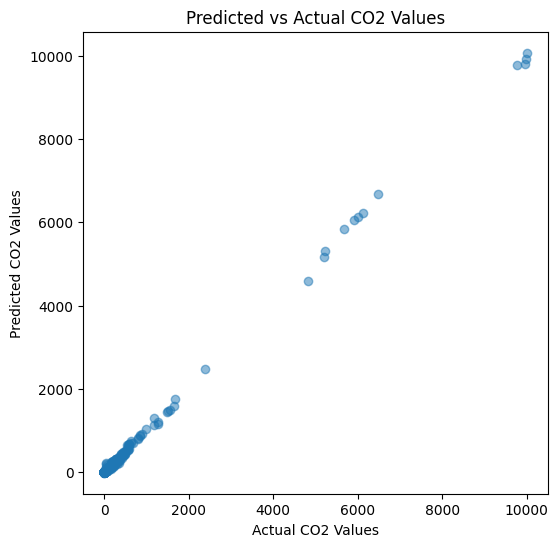

In [81]:
#Seems like Lasso performs the best which is to be expected.

import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, linear_predictions, alpha=0.5)
plt.xlabel('Actual CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Predicted vs Actual CO2 Values')
plt.show()

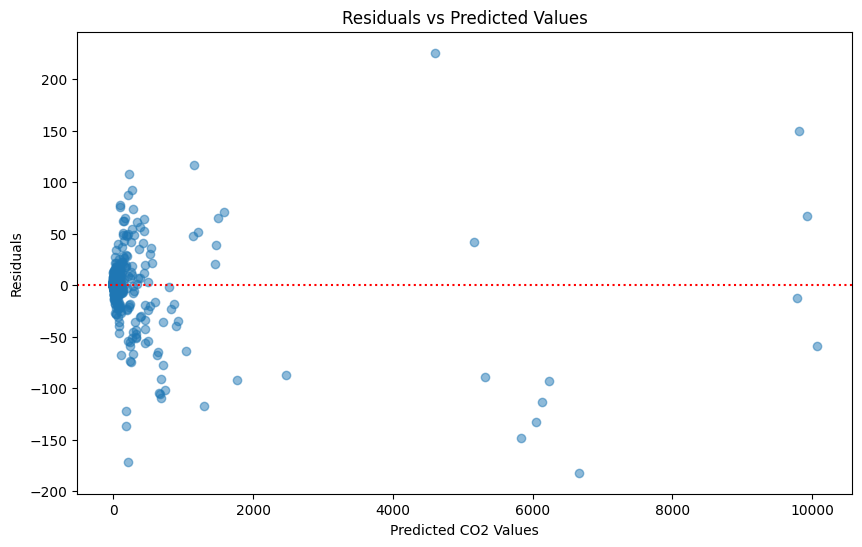

In [82]:
# Assuming you have your actual and predicted values as follows:
actual_values = y_test
predicted_values = linear_predictions

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted CO2 Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle=':')  # Adds a horizontal line at zero
plt.show()